In [1]:
#define path
kaggle_ds = "/files"
main_path = "../raw_dataset"

In [2]:
#choose the dataset
chooser = kaggle_ds

In [3]:
DATASET_PATH = main_path+chooser
# DATASET_PATH = "../../../Music"
JSON_PATH = '../pr_dataset/myjson2.json'
SAMPLE_RATE = sr =  22050
DURATION = 30 #measured in seconds 
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(main_path+chooser):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        print(filename)
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3
010. DJ Snake feat. Lauv - A Different Way (.mp3
03 Down On Love (Moksi Remix).mp3
04 Kill It.mp3
04. Tujamo - One On One (Vion Konger Remix) .mp3
10. Sikdope - Snakes (Extended Mix).mp3
10161324_The_Game_Original_Mix.mp3
10582469_Antidote_Extended_Mix.mp3
11073789_Get_Down_Extended_Mix.mp3
205. Diplo And Autoerotique - Waist Time.mp3
4B _ Teez - Whistle (Schade Remix).mp3
9416773_No_More_Original_Mix.mp3
Afrojack - Bassride (Extended Mix) #BassHous.mp3
Albin Myers feat. Bud Stankz - Walking On Wa.mp3
Alenn, NEOX - Spiral [www.slider.kz].mp3
Alesso - Falling (Brohug remix) (125)-1.mp3
Artelax - Crank It (Extended Mix).mp3
AWIIN - Brotality (Extended Mix).mp3
Bart B More - Throwback [www.slider.kz].mp3
Bassride - Congratulations [DemoDrop].mp3
Basstrick - Ghost Buster (Original Mix) [sic.mp3
Be (BROHUG Remix).mp3
Boombox-Cartel---Moon-Love-ft.-Nessly-_Tha-B.mp3
Brohug  - Ambush (Extended Mix) .mp3
BROHUG - Paparazzi (Extended Mix) [www.sl

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import soundfile as sf
# import librosa
# import librosa.display
from IPython.display import Audio
# from tqdm import tqdm 
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
import os
import math
import json
import random

In [16]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    #dictionary to store data
    data = {
        'mapping' : [],
        'mfcc' : [],
        'labels' : []
    }
    
    count = 0 # To keep track of our progress
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) 
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    #Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not at the root level
        if dirpath not in dataset_path:

            #save the semantic label
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data['mapping'].append(semantic_label)
            print('\nProcessing {}'.format(semantic_label))
            
            #process files for a specific genre 
            for f in filenames:
#                 if f.endswith('.wav') and f != 'jazz.00054.wav': # Since file jazz.00054.wav is an empty file
                if True: # Since file jazz.00054.wav is an empty file
                    file_path = os.path.join(dirpath,f)
                    
                    #loading the audio file 
                    # we are using the soundfile library since it is faster than librosa
                    signal, sr = librosa.load(file_path) # len(signal) = 661794  # sr is 22050 by default 
                    #print(signal,sr)
                    #process segments extracting mfcc and storing data
                    for s in range(num_segments): 
                        # Since num_segments is defined as 5. Every 30 sec file is divided into 5 segments of length 6sec 
                        # Start sample would keep track of the index of the first element of each 6 second batch
                        # finish sample would keep track of the index of the last element of each 6 second batch
                        # And then with the help of python's slice functionality we will extract that 6 second batch from every 30 sec signal
                        start_sample = num_samples_per_segment * s   
                        finish_sample = num_samples_per_segment + start_sample
                        
                        # Next, we will pass each segment in order to extract MFCC. The parameter n_mfcc defines the number of mfcc 
                        # we need to extract, Usually n_mfcc is set b/w 13 to 40. The other parameters n_fft and hop length are 
                        # indivisual topics of discussion. Will be discussed in later Notbooks. 
                        mfcc = librosa.feature.mfcc(signal[60+start_sample : 60+finish_sample],
                                                   sr = sr,
                                                   n_fft = n_fft,
                                                   n_mfcc = n_mfcc,
                                                   hop_length = hop_length)

                        mfcc = mfcc.T
                        # store mfcc for segment if it has the expected length
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            print(mfcc.shape)
                            data['mfcc'].append(mfcc.tolist())
                            data['labels'].append(i)
                            print('Processing {}, segment:{}'.format(file_path, s))
                            count += 1
                            print(count)
    with open(json_path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [17]:
# Let's run the above function 
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing files\BASS HOUSE
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:0
1
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:1
2
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:2
3
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:3
4
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:4
5
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:5
6
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:6
7
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Castion _ Dylerz feat. NEAD - Take Me (Ex.mp3, segment:7
8
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\01 Cast

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\10582469_Antidote_Extended_Mix.mp3, segment:9
80
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:0
81
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:1
82
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:2
83
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:3
84
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:4
85
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:5
86
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:6
87
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, segment:7
88
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\11073789_Get_Down_Extended_Mix.mp3, seg

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:6
157
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:7
158
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:8
159
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Alesso - Falling (Brohug remix) (125)-1.mp3, segment:9
160
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:0
161
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:1
162
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:2
163
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:3
164
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Artelax - Crank It (Extended Mix).mp3, segment:4
165
(65, 13)
Processing ../raw_data

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:4
235
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:5
236
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:6
237
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:7
238
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:8
239
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Brohug  - Ambush (Extended Mix) .mp3, segment:9
240
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\BROHUG - Paparazzi (Extended Mix) [www.slide.mp3, segment:0
241
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\BROHUG - Paparazzi (Extended Mix) [www.slide.mp3, segment:1
242
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\BROHUG - Paparazzi (Extended Mix) [www.slide.mp3, segment:2
243
(65, 13)
Processing ../raw_d

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:0
311
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:1
312
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:2
313
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:3
314
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:4
315
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:5
316
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:6
317
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique x Benny Benassi - Waist.mp3, segment:7
318
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Diplo _ Autoerotique

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:2
383
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:3
384
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:4
385
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:5
386
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:6
387
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:7
388
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:8
389
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Faux - No Mercy (Clean Extended).mp3, segment:9
390
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\FineRefined _ DVNCAN - LOW.wav, segment:0
391
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\FineRefined _ DVNC

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Gerald le Funk _ Ricky West - I Feel Like.mp3, segment:8
459
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Gerald le Funk _ Ricky West - I Feel Like.mp3, segment:9
460
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:0
461
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:1
462
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:2
463
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:3
464
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:4
465
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (feat. TITUS) [Extend.mp3, segment:5
466
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Guy Arthur - Get Money (fe

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:0
531
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:1
532
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:2
533
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:3
534
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:4
535
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:5
536
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:6
537
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Музыка Мафия] [www.slider.k.mp3, segment:7
538
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Jebu - Go Ahead [Муз

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Loopers - Drummachine (Original Mix) [SWM].mp3, segment:7
608
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Loopers - Drummachine (Original Mix) [SWM].mp3, segment:8
609
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Loopers - Drummachine (Original Mix) [SWM].mp3, segment:9
610
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\LOUD ABOUT US! x ATRIP - Bassline Spinner.wav, segment:0
611
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\LOUD ABOUT US! x ATRIP - Bassline Spinner.wav, segment:1
612
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\LOUD ABOUT US! x ATRIP - Bassline Spinner.wav, segment:2
613
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\LOUD ABOUT US! x ATRIP - Bassline Spinner.wav, segment:3
614
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\LOUD ABOUT US! x ATRIP - Bassline Spinner.wav, segment:4
615
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\LOUD ABOUT US! x ATRIP - Bassline Spinner

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Midnight Quickie _ Bleu Clair - Getaway (Ori.mp3, segment:2
683
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Midnight Quickie _ Bleu Clair - Getaway (Ori.mp3, segment:3
684
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Midnight Quickie _ Bleu Clair - Getaway (Ori.mp3, segment:4
685
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Midnight Quickie _ Bleu Clair - Getaway (Ori.mp3, segment:5
686
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Midnight Quickie _ Bleu Clair - Getaway (Ori.mp3, segment:6
687
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Midnight Quickie _ Bleu Clair - Getaway (Ori.mp3, segment:7
688
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Midnight Quickie _ Bleu Clair - Getaway (Ori.mp3, segment:8
689
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Midnight Quickie _ Bleu Clair - Getaway (Ori.mp3, segment:9
690
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Mightyfools - Damn G

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MRZY - Bootyshake (Original Mix).mp3, segment:6
757
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MRZY - Bootyshake (Original Mix).mp3, segment:7
758
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MRZY - Bootyshake (Original Mix).mp3, segment:8
759
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MRZY - Bootyshake (Original Mix).mp3, segment:9
760
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MYLØ - Dealer [www.slider.kz].mp3, segment:0
761
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MYLØ - Dealer [www.slider.kz].mp3, segment:1
762
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MYLØ - Dealer [www.slider.kz].mp3, segment:2
763
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MYLØ - Dealer [www.slider.kz].mp3, segment:3
764
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MYLØ - Dealer [www.slider.kz].mp3, segment:4
765
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\MYLØ - Dealer [www.slider.k

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quiet Disorder - Trippin__Cmp3.eu.mp3, segment:6
837
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quiet Disorder - Trippin__Cmp3.eu.mp3, segment:7
838
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quiet Disorder - Trippin__Cmp3.eu.mp3, segment:8
839
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quiet Disorder - Trippin__Cmp3.eu.mp3, segment:9
840
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quintino _ Alvaro - Dem Shots.mp3, segment:0
841
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quintino _ Alvaro - Dem Shots.mp3, segment:1
842
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quintino _ Alvaro - Dem Shots.mp3, segment:2
843
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quintino _ Alvaro - Dem Shots.mp3, segment:3
844
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quintino _ Alvaro - Dem Shots.mp3, segment:4
845
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Quintino _ Alvaro - Dem

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Siberian Express x Richie Loop - Xpress (Ori.wav, segment:2
913
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Siberian Express x Richie Loop - Xpress (Ori.wav, segment:3
914
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Siberian Express x Richie Loop - Xpress (Ori.wav, segment:4
915
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Siberian Express x Richie Loop - Xpress (Ori.wav, segment:5
916
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Siberian Express x Richie Loop - Xpress (Ori.wav, segment:6
917
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Siberian Express x Richie Loop - Xpress (Ori.wav, segment:7
918
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Siberian Express x Richie Loop - Xpress (Ori.wav, segment:8
919
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Siberian Express x Richie Loop - Xpress (Ori.wav, segment:9
920
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Sikdope _ ZOOTAH - B

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:5
986
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:6
987
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:7
988
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:8
989
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Steff Da Campo, twoloud - House Party (Reebs.mp3, segment:9
990
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Subshock _ Evangelos - Feeling (Extended mix.wav, segment:0
991
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Subshock _ Evangelos - Feeling (Extended mix.wav, segment:1
992
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Subshock _ Evangelos - Feeling (Extended mix.wav, segment:2
993
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Subshock _ Evangelos

(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Valy Mo - Brain Rock [www.slider.kz].mp3, segment:8
1059
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\Valy Mo - Brain Rock [www.slider.kz].mp3, segment:9
1060
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:0
1061
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:1
1062
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:2
1063
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:3
1064
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:4
1065
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:5
1066
(65, 13)
Processing ../raw_dataset/files\BASS HOUSE\WATEVA - Ber Zer Ker [www.slider.kz].mp3, segment:6
1067
(65, 13)
Processing

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ANG _ Lemarroy - World In My Hands (Exten.wav, segment:2
1133
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ANG _ Lemarroy - World In My Hands (Exten.wav, segment:3
1134
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ANG _ Lemarroy - World In My Hands (Exten.wav, segment:4
1135
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ANG _ Lemarroy - World In My Hands (Exten.wav, segment:5
1136
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ANG _ Lemarroy - World In My Hands (Exten.wav, segment:6
1137
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ANG _ Lemarroy - World In My Hands (Exten.wav, segment:7
1138
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ANG _ Lemarroy - World In My Hands (Exten.wav, segment:8
1139
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ANG _ Lemarroy - World In My Hands (Exten.wav, segment:9
1140
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 ARTIN - Hydra (Extended Mix

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jack _ James - Aftermath (Extended Mix).mp3, segment:6
1207
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jack _ James - Aftermath (Extended Mix).mp3, segment:7
1208
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jack _ James - Aftermath (Extended Mix).mp3, segment:8
1209
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jack _ James - Aftermath (Extended Mix).mp3, segment:9
1210
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jenil _ Starjack feat. SEDANOxSTRØ- Switc.wav, segment:0
1211
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jenil _ Starjack feat. SEDANOxSTRØ- Switc.wav, segment:1
1212
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jenil _ Starjack feat. SEDANOxSTRØ- Switc.wav, segment:2
1213
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jenil _ Starjack feat. SEDANOxSTRØ- Switc.wav, segment:3
1214
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Jenil _ Starjack feat. SEDANOxSTRØ-

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:0
1281
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:1
1282
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:2
1283
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:3
1284
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:4
1285
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:5
1286
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:6
1287
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:7
1288
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Extended Mix).mp3, segment:8
1289
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 NAEMS - Ritual (Exte

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 STVW _ VillanZ - Lean Back (Extended Mix).mp3, segment:6
1357
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 STVW _ VillanZ - Lean Back (Extended Mix).mp3, segment:7
1358
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 STVW _ VillanZ - Lean Back (Extended Mix).mp3, segment:8
1359
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 STVW _ VillanZ - Lean Back (Extended Mix).mp3, segment:9
1360
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Subliminals _ Cytrax - Speaker (Extended .mp3, segment:0
1361
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Subliminals _ Cytrax - Speaker (Extended .mp3, segment:1
1362
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Subliminals _ Cytrax - Speaker (Extended .mp3, segment:2
1363
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Subliminals _ Cytrax - Speaker (Extended .mp3, segment:3
1364
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\01 Subliminals _ Cytrax - Spea

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\063.  David Guetta feat. Justin Bieber - 2U .mp3, segment:4
1435
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\063.  David Guetta feat. Justin Bieber - 2U .mp3, segment:5
1436
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\063.  David Guetta feat. Justin Bieber - 2U .mp3, segment:6
1437
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\063.  David Guetta feat. Justin Bieber - 2U .mp3, segment:7
1438
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\063.  David Guetta feat. Justin Bieber - 2U .mp3, segment:8
1439
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\063.  David Guetta feat. Justin Bieber - 2U .mp3, segment:9
1440
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\07- Regard - Ride It (Dimitri Vegas _ Like M.mp3, segment:0
1441
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\07- Regard - Ride It (Dimitri Vegas _ Like M.mp3, segment:1
1442
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\07- Regard - Ride It (Dimitri 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11514044_Hard_Extended_Mix.mp3, segment:2
1513
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11514044_Hard_Extended_Mix.mp3, segment:3
1514
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11514044_Hard_Extended_Mix.mp3, segment:4
1515
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11514044_Hard_Extended_Mix.mp3, segment:5
1516
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11514044_Hard_Extended_Mix.mp3, segment:6
1517
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11514044_Hard_Extended_Mix.mp3, segment:7
1518
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11514044_Hard_Extended_Mix.mp3, segment:8
1519
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11514044_Hard_Extended_Mix.mp3, segment:9
1520
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11935774_Hands_Up_Extended_Mix.mp3, segment:0
1521
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\11935774_Hands_Up_Extended_Mix.mp3, segment:1
1522
(65, 13)
Processing ..

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14. Sandro Silva, Max Adrian _ Rion - Genesi.mp3, segment:9
1590
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14044056_You_re_The_Future_Extended_Mix.mp3, segment:0
1591
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14044056_You_re_The_Future_Extended_Mix.mp3, segment:1
1592
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14044056_You_re_The_Future_Extended_Mix.mp3, segment:2
1593
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14044056_You_re_The_Future_Extended_Mix.mp3, segment:3
1594
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14044056_You_re_The_Future_Extended_Mix.mp3, segment:4
1595
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14044056_You_re_The_Future_Extended_Mix.mp3, segment:5
1596
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14044056_You_re_The_Future_Extended_Mix.mp3, segment:6
1597
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\14044056_You_re_The_Future_Extended_Mix.mp3, segment:7
1598
(65, 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Adrian Moore - Top Boy (Extended Mix).mp3, segment:4
1665
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Adrian Moore - Top Boy (Extended Mix).mp3, segment:5
1666
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Adrian Moore - Top Boy (Extended Mix).mp3, segment:6
1667
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Adrian Moore - Top Boy (Extended Mix).mp3, segment:7
1668
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Adrian Moore - Top Boy (Extended Mix).mp3, segment:8
1669
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Adrian Moore - Top Boy (Extended Mix).mp3, segment:9
1670
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Africa (Original Mix).mp3, segment:0
1671
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Africa (Original Mix).mp3, segment:1
1672
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Africa (Original Mix).mp3, segment:2
1673
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Africa (Original Mix).mp3,

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Martin Garrix - Turn Up The Speake.mp3, segment:8
1739
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Afrojack, Martin Garrix - Turn Up The Speake.mp3, segment:9
1740
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Aftermarket x Zinko x Slowminded - Trembling.mp3, segment:0
1741
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Aftermarket x Zinko x Slowminded - Trembling.mp3, segment:1
1742
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Aftermarket x Zinko x Slowminded - Trembling.mp3, segment:2
1743
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Aftermarket x Zinko x Slowminded - Trembling.mp3, segment:3
1744
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Aftermarket x Zinko x Slowminded - Trembling.mp3, segment:4
1745
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Aftermarket x Zinko x Slowminded - Trembling.mp3, segment:5
1746
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Aftermarket x Zinko x Slowmind

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than You Know (Umme.wav, segment:0
1811
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than You Know (Umme.wav, segment:1
1812
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than You Know (Umme.wav, segment:2
1813
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than You Know (Umme.wav, segment:3
1814
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than You Know (Umme.wav, segment:4
1815
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than You Know (Umme.wav, segment:5
1816
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than You Know (Umme.wav, segment:6
1817
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than You Know (Umme.wav, segment:7
1818
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Axwell _ Ingrosso - More Than 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - The Riddle [www.slider.kz].mp3, segment:4
1885
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - The Riddle [www.slider.kz].mp3, segment:5
1886
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - The Riddle [www.slider.kz].mp3, segment:6
1887
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - The Riddle [www.slider.kz].mp3, segment:7
1888
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - The Riddle [www.slider.kz].mp3, segment:8
1889
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers - The Riddle [www.slider.kz].mp3, segment:9
1890
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers Vs Skytech Vs Alan Walker - Pill.mp3, segment:0
1891
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers Vs Skytech Vs Alan Walker - Pill.mp3, segment:1
1892
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Bassjackers Vs Skytech Vs Alan Walker - Pill.mp3, segm

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:6
1957
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:7
1958
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:8
1959
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - No Sleep (Extended Mix) [www.s.mp3, segment:9
1960
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - Party All Week (feat. Jamez) [.mp3, segment:0
1961
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - Party All Week (feat. Jamez) [.mp3, segment:1
1962
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - Party All Week (feat. Jamez) [.mp3, segment:2
1963
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - Party All Week (feat. Jamez) [.mp3, segment:3
1964
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Blasterjaxx - Party All Week (

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:2
2033
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:3
2034
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:4
2035
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:5
2036
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:6
2037
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:7
2038
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:8
2039
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\BreakdeX _ Dastven - Pardo (Extended Mix).mp3, segment:9
2040
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Brooks GRX vs Dua Lipa - Boomerang vs New Ru.wav, segm

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Chocolate Puma - Make _#39_M Bounce (Extende.mp3, segment:8
2109
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Chocolate Puma - Make _#39_M Bounce (Extende.mp3, segment:9
2110
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:0
2111
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:1
2112
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:2
2113
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:3
2114
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:4
2115
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmatico (Extended M.mp3, segment:5
2116
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Code Key _ Neev Dam - Voltmati

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:2
2183
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:3
2184
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:4
2185
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:5
2186
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:6
2187
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:7
2188
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:8
2189
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dance All Night vs. BARRACA (New Sound Natio.mp3, segment:9
2190
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dannic _ Bougenvilla - Ctrl Al

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:4
2255
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:5
2256
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:6
2257
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:7
2258
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:8
2259
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dirty Ducks _ Hawkboy - Outlaw (Extended Mix.mp3, segment:9
2260
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- Let Me Love You.mp3, segment:0
2261
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- Let Me Love You.mp3, segment:1
2262
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dj Snake feat Justin Bieber- L

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dzeko Vs. Riggi _ Piros Ft. Veronica - Heave.mp3, segment:8
2329
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Dzeko Vs. Riggi _ Piros Ft. Veronica - Heave.mp3, segment:9
2330
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Edd Blaze _ Moraii - Keep It Lit (Extended M.mp3, segment:0
2331
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Edd Blaze _ Moraii - Keep It Lit (Extended M.mp3, segment:1
2332
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Edd Blaze _ Moraii - Keep It Lit (Extended M.mp3, segment:2
2333
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Edd Blaze _ Moraii - Keep It Lit (Extended M.mp3, segment:3
2334
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Edd Blaze _ Moraii - Keep It Lit (Extended M.mp3, segment:4
2335
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Edd Blaze _ Moraii - Keep It Lit (Extended M.mp3, segment:5
2336
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Edd Blaze _ Moraii - Keep It L

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FLEXX _ Max Adrian - Bandit (Original Mix) F.mp3, segment:6
2407
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FLEXX _ Max Adrian - Bandit (Original Mix) F.mp3, segment:7
2408
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FLEXX _ Max Adrian - Bandit (Original Mix) F.mp3, segment:8
2409
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FLEXX _ Max Adrian - Bandit (Original Mix) F.mp3, segment:9
2410
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FTampa - F.I.A. (Extended Mix) [www.slider.k.mp3, segment:0
2411
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FTampa - F.I.A. (Extended Mix) [www.slider.k.mp3, segment:1
2412
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FTampa - F.I.A. (Extended Mix) [www.slider.k.mp3, segment:2
2413
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FTampa - F.I.A. (Extended Mix) [www.slider.k.mp3, segment:3
2414
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\FTampa - F.I.A. (Extended Mix)

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Cent vs Ummet Oz.mp3, segment:0
2481
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Cent vs Ummet Oz.mp3, segment:1
2482
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Cent vs Ummet Oz.mp3, segment:2
2483
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Cent vs Ummet Oz.mp3, segment:3
2484
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Cent vs Ummet Oz.mp3, segment:4
2485
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Cent vs Ummet Oz.mp3, segment:5
2486
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Cent vs Ummet Oz.mp3, segment:6
2487
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Cent vs Ummet Oz.mp3, segment:7
2488
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell  Blasterjaxx vs 50 Ce

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Maddix - Smash This Beat (Artelax.mp3, segment:2
2553
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Maddix - Smash This Beat (Artelax.mp3, segment:3
2554
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Maddix - Smash This Beat (Artelax.mp3, segment:4
2555
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Maddix - Smash This Beat (Artelax.mp3, segment:5
2556
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Maddix - Smash This Beat (Artelax.mp3, segment:6
2557
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Maddix - Smash This Beat (Artelax.mp3, segment:7
2558
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Maddix - Smash This Beat (Artelax.mp3, segment:8
2559
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Maddix - Smash This Beat (Artelax.mp3, segment:9
2560
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Hardwell _ Quintino - Woest (E

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong _ Reece Low - Slapjack (Original .mp3, segment:4
2625
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong _ Reece Low - Slapjack (Original .mp3, segment:5
2626
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong _ Reece Low - Slapjack (Original .mp3, segment:6
2627
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong _ Reece Low - Slapjack (Original .mp3, segment:7
2628
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong _ Reece Low - Slapjack (Original .mp3, segment:8
2629
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong _ Reece Low - Slapjack (Original .mp3, segment:9
2630
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong, Halfway House feat. Sanjin - F.E.mp3, segment:0
2631
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong, Halfway House feat. Sanjin - F.E.mp3, segment:1
2632
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Henry Fong, Halfway House feat

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway - Aliens (Extended Mix).mp3, segment:2
2703
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway - Aliens (Extended Mix).mp3, segment:3
2704
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway - Aliens (Extended Mix).mp3, segment:4
2705
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway - Aliens (Extended Mix).mp3, segment:5
2706
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway - Aliens (Extended Mix).mp3, segment:6
2707
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway - Aliens (Extended Mix).mp3, segment:7
2708
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway - Aliens (Extended Mix).mp3, segment:8
2709
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway - Aliens (Extended Mix).mp3, segment:9
2710
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Jay Hardway _ Mike Cervello - EDM Bubble (Ex.mp3, segment:0
2711
(65, 13)
Processing ../raw_dataset/fi

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Justin Prime, Reggio - Speaker Test (Club Mi.mp3, segment:6
2777
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Justin Prime, Reggio - Speaker Test (Club Mi.mp3, segment:7
2778
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Justin Prime, Reggio - Speaker Test (Club Mi.mp3, segment:8
2779
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Justin Prime, Reggio - Speaker Test (Club Mi.mp3, segment:9
2780
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kaaze — Sexy (Steven Vegas Extended Mix).mp3, segment:0
2781
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kaaze — Sexy (Steven Vegas Extended Mix).mp3, segment:1
2782
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kaaze — Sexy (Steven Vegas Extended Mix).mp3, segment:2
2783
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kaaze — Sexy (Steven Vegas Extended Mix).mp3, segment:3
2784
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kaaze — Sexy (Steven Vegas Extended Mix).mp3, 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\KIIDA vs. J-Trick - KIIDA vs. J-Trick - Lose.mp3, segment:8
2849
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\KIIDA vs. J-Trick - KIIDA vs. J-Trick - Lose.mp3, segment:9
2850
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kill The Buzz _ Loris Cimino - Attack (Are Y.mp3, segment:0
2851
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kill The Buzz _ Loris Cimino - Attack (Are Y.mp3, segment:1
2852
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kill The Buzz _ Loris Cimino - Attack (Are Y.mp3, segment:2
2853
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kill The Buzz _ Loris Cimino - Attack (Are Y.mp3, segment:3
2854
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kill The Buzz _ Loris Cimino - Attack (Are Y.mp3, segment:4
2855
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kill The Buzz _ Loris Cimino - Attack (Are Y.mp3, segment:5
2856
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Kill The Buzz _ Loris Cimino -

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Laidback Luke _ Ale Mora - Milkshake (Better.mp3, segment:4
2925
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Laidback Luke _ Ale Mora - Milkshake (Better.mp3, segment:5
2926
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Laidback Luke _ Ale Mora - Milkshake (Better.mp3, segment:6
2927
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Laidback Luke _ Ale Mora - Milkshake (Better.mp3, segment:7
2928
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Laidback Luke _ Ale Mora - Milkshake (Better.mp3, segment:8
2929
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Laidback Luke _ Ale Mora - Milkshake (Better.mp3, segment:9
2930
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Leadhunterz - Yoddha (Extended Mix).mp3, segment:0
2931
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Leadhunterz - Yoddha (Extended Mix).mp3, segment:1
2932
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Leadhunterz - Yoddha (Extended Mix).mp3, segment

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix - Technology (Extended Mix) [www.sl-1.mp3, segment:8
2999
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix - Technology (Extended Mix) [www.sl-1.mp3, segment:9
3000
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix vs TJR _ Vinai vs Zedd _ Maren Morr-1.mp3, segment:0
3001
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix vs TJR _ Vinai vs Zedd _ Maren Morr-1.mp3, segment:1
3002
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix vs TJR _ Vinai vs Zedd _ Maren Morr-1.mp3, segment:2
3003
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix vs TJR _ Vinai vs Zedd _ Maren Morr-1.mp3, segment:3
3004
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix vs TJR _ Vinai vs Zedd _ Maren Morr-1.mp3, segment:4
3005
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix vs TJR _ Vinai vs Zedd _ Maren Morr-1.mp3, segment:5
3006
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maddix vs TJR _ Vinai vs Zedd 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - Boogie Machine (Extended Mix).mp3, segment:2
3073
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - Boogie Machine (Extended Mix).mp3, segment:3
3074
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - Boogie Machine (Extended Mix).mp3, segment:4
3075
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - Boogie Machine (Extended Mix).mp3, segment:5
3076
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - Boogie Machine (Extended Mix).mp3, segment:6
3077
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - Boogie Machine (Extended Mix).mp3, segment:7
3078
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - Boogie Machine (Extended Mix).mp3, segment:8
3079
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - Boogie Machine (Extended Mix).mp3, segment:9
3080
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Maurice West - In The Zone [ww

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rave Child (Extended Mix) [w.mp3, segment:5
3146
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rave Child (Extended Mix) [w.mp3, segment:6
3147
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rave Child (Extended Mix) [w.mp3, segment:7
3148
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rave Child (Extended Mix) [w.mp3, segment:8
3149
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rave Child (Extended Mix) [w.mp3, segment:9
3150
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rotation (Extended Mix) [www.mp3, segment:0
3151
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rotation (Extended Mix) [www.mp3, segment:1
3152
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rotation (Extended Mix) [www.mp3, segment:2
3153
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mike Cervello - Rotation (Exte

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mountblaq _ VillanZ - BRAA [13.10.2017] [FDM.mp3, segment:8
3219
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mountblaq _ VillanZ - BRAA [13.10.2017] [FDM.mp3, segment:9
3220
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mr. Black, WAO - Hu Ha [www.slider.kz].mp3, segment:0
3221
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mr. Black, WAO - Hu Ha [www.slider.kz].mp3, segment:1
3222
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mr. Black, WAO - Hu Ha [www.slider.kz].mp3, segment:2
3223
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mr. Black, WAO - Hu Ha [www.slider.kz].mp3, segment:3
3224
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mr. Black, WAO - Hu Ha [www.slider.kz].mp3, segment:4
3225
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mr. Black, WAO - Hu Ha [www.slider.kz].mp3, segment:5
3226
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Mr. Black, WAO - Hu Ha [www.slider.kz].mp3, segment:6
3227
(65, 13

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Champion Sound (Ex.mp3, segment:0
3291
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Champion Sound (Ex.mp3, segment:1
3292
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Champion Sound (Ex.mp3, segment:2
3293
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Champion Sound (Ex.mp3, segment:3
3294
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Champion Sound (Ex.mp3, segment:4
3295
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Champion Sound (Ex.mp3, segment:5
3296
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Champion Sound (Ex.mp3, segment:6
3297
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Champion Sound (Ex.mp3, segment:7
3298
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Nicky Romero _ Teamworx - Cham

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\One Bounce Generation (Afrojack UMF 2019 Eur.mp3, segment:4
3365
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\One Bounce Generation (Afrojack UMF 2019 Eur.mp3, segment:5
3366
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\One Bounce Generation (Afrojack UMF 2019 Eur.mp3, segment:6
3367
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\One Bounce Generation (Afrojack UMF 2019 Eur.mp3, segment:7
3368
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\One Bounce Generation (Afrojack UMF 2019 Eur.mp3, segment:8
3369
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\One Bounce Generation (Afrojack UMF 2019 Eur.mp3, segment:9
3370
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Pessto _ FLEXX - Da Beat [Final Master].wav, segment:0
3371
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Pessto _ FLEXX - Da Beat [Final Master].wav, segment:1
3372
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Pessto _ FLEXX - Da Beat [Final Master].

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Crossnaders - EMF [www.slider.kz].mp3, segment:8
3439
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Crossnaders - EMF [www.slider.kz].mp3, segment:9
3440
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Killfake - Undercovers (Extended .mp3, segment:0
3441
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Killfake - Undercovers (Extended .mp3, segment:1
3442
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Killfake - Undercovers (Extended .mp3, segment:2
3443
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Killfake - Undercovers (Extended .mp3, segment:3
3444
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Killfake - Undercovers (Extended .mp3, segment:4
3445
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Killfake - Undercovers (Extended .mp3, segment:5
3446
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Quintino _ Killfake - Undercov

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Robert Falcon _ D3FAI - System X (Extended M.mp3, segment:2
3513
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Robert Falcon _ D3FAI - System X (Extended M.mp3, segment:3
3514
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Robert Falcon _ D3FAI - System X (Extended M.mp3, segment:4
3515
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Robert Falcon _ D3FAI - System X (Extended M.mp3, segment:5
3516
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Robert Falcon _ D3FAI - System X (Extended M.mp3, segment:6
3517
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Robert Falcon _ D3FAI - System X (Extended M.mp3, segment:7
3518
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Robert Falcon _ D3FAI - System X (Extended M.mp3, segment:8
3519
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Robert Falcon _ D3FAI - System X (Extended M.mp3, segment:9
3520
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Rock It Fire (PuFFcorn Mashup)

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastian Mateo _ Blackbusters - Like This [.mp3, segment:6
3587
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastian Mateo _ Blackbusters - Like This [.mp3, segment:7
3588
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastian Mateo _ Blackbusters - Like This [.mp3, segment:8
3589
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastian Mateo _ Blackbusters - Like This [.mp3, segment:9
3590
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastien Castillo - Lynx (Extended Mix).mp3, segment:0
3591
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastien Castillo - Lynx (Extended Mix).mp3, segment:1
3592
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastien Castillo - Lynx (Extended Mix).mp3, segment:2
3593
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastien Castillo - Lynx (Extended Mix).mp3, segment:3
3594
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Sebastien Castillo - Lynx (Extended Mix).mp3, 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted All My Time (.mp3, segment:0
3661
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted All My Time (.mp3, segment:1
3662
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted All My Time (.mp3, segment:2
3663
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted All My Time (.mp3, segment:3
3664
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted All My Time (.mp3, segment:4
3665
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted All My Time (.mp3, segment:5
3666
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted All My Time (.mp3, segment:6
3667
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted All My Time (.mp3, segment:7
3668
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Skarleth _ Victor H - I Wasted

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steven Vegas vs TJR vs Hardwell ft Chris Jon.wav, segment:2
3733
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steven Vegas vs TJR vs Hardwell ft Chris Jon.wav, segment:3
3734
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steven Vegas vs TJR vs Hardwell ft Chris Jon.wav, segment:4
3735
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steven Vegas vs TJR vs Hardwell ft Chris Jon.wav, segment:5
3736
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steven Vegas vs TJR vs Hardwell ft Chris Jon.wav, segment:6
3737
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steven Vegas vs TJR vs Hardwell ft Chris Jon.wav, segment:7
3738
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steven Vegas vs TJR vs Hardwell ft Chris Jon.wav, segment:8
3739
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Steven Vegas vs TJR vs Hardwell ft Chris Jon.wav, segment:9
3740
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Subliminals, Breakdex - Night 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TBR _ Ragunde - Final Destination (Extended .mp3, segment:7
3808
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TBR _ Ragunde - Final Destination (Extended .mp3, segment:8
3809
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\TBR _ Ragunde - Final Destination (Extended .mp3, segment:9
3810
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:0
3811
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:1
3812
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:2
3813
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:3
3814
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:4
3815
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Teamworx - Clap Back [www.slider.kz].mp3, segment:5
3816
(65, 13)
Proc

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Thomas Newson - Combat  [www.slider.kz].mp3, segment:4
3885
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Thomas Newson - Combat  [www.slider.kz].mp3, segment:5
3886
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Thomas Newson - Combat  [www.slider.kz].mp3, segment:6
3887
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Thomas Newson - Combat  [www.slider.kz].mp3, segment:7
3888
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Thomas Newson - Combat  [www.slider.kz].mp3, segment:8
3889
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Thomas Newson - Combat  [www.slider.kz].mp3, segment:9
3890
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto _ Dzeko - Jackie Chan (Tiesto Big Roo.mp3, segment:0
3891
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto _ Dzeko - Jackie Chan (Tiesto Big Roo.mp3, segment:1
3892
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tiesto _ Dzeko - Jackie Chan (Tiesto Big Roo.mp3, segment:2


(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tommie Sunshine _ Krunk! - Bang Boom (Extend.mp3, segment:7
3958
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tommie Sunshine _ Krunk! - Bang Boom (Extend.mp3, segment:8
3959
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tommie Sunshine _ Krunk! - Bang Boom (Extend.mp3, segment:9
3960
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Igy vs Avicii - Astronomia vs Waiting F.wav, segment:0
3961
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Igy vs Avicii - Astronomia vs Waiting F.wav, segment:1
3962
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Igy vs Avicii - Astronomia vs Waiting F.wav, segment:2
3963
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Igy vs Avicii - Astronomia vs Waiting F.wav, segment:3
3964
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Igy vs Avicii - Astronomia vs Waiting F.wav, segment:4
3965
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Tony Igy vs Avicii - Astronomi

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Ummet Ozcan, Arman Aydin, Arem Ozguc - IZMIR.mp3, segment:4
4035
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Ummet Ozcan, Arman Aydin, Arem Ozguc - IZMIR.mp3, segment:5
4036
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Ummet Ozcan, Arman Aydin, Arem Ozguc - IZMIR.mp3, segment:6
4037
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Ummet Ozcan, Arman Aydin, Arem Ozguc - IZMIR.mp3, segment:7
4038
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Ummet Ozcan, Arman Aydin, Arem Ozguc - IZMIR.mp3, segment:8
4039
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Ummet Ozcan, Arman Aydin, Arem Ozguc - IZMIR.mp3, segment:9
4040
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\VITIZE _ Andrew Belize - MSHP (RSPWN Edit) [.mp3, segment:0
4041
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\VITIZE _ Andrew Belize - MSHP (RSPWN Edit) [.mp3, segment:1
4042
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\VITIZE _ Andrew Belize - MSHP 

(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Xavi - Kora (Original Mix) [www.slider.kz].mp3, segment:8
4109
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Xavi - Kora (Original Mix) [www.slider.kz].mp3, segment:9
4110
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Yosmer Davis _ Alonso - Rock It (Extended Mi.mp3, segment:0
4111
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Yosmer Davis _ Alonso - Rock It (Extended Mi.mp3, segment:1
4112
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Yosmer Davis _ Alonso - Rock It (Extended Mi.mp3, segment:2
4113
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Yosmer Davis _ Alonso - Rock It (Extended Mi.mp3, segment:3
4114
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Yosmer Davis _ Alonso - Rock It (Extended Mi.mp3, segment:4
4115
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Yosmer Davis _ Alonso - Rock It (Extended Mi.mp3, segment:5
4116
(65, 13)
Processing ../raw_dataset/files\BIG ROOM\Yosmer Davis _ Alonso - Rock It (E

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\01-Claes-Rosen-Daydreaming.mp3, segment:4
4185
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\01-Claes-Rosen-Daydreaming.mp3, segment:5
4186
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\01-Claes-Rosen-Daydreaming.mp3, segment:6
4187
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\01-Claes-Rosen-Daydreaming.mp3, segment:7
4188
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\01-Claes-Rosen-Daydreaming.mp3, segment:8
4189
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\01-Claes-Rosen-Daydreaming.mp3, segment:9
4190
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\06. I Want Your Attention.mp3, segment:0
4191
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\06. I Want Your Attention.mp3, segment:1
4192
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\06. I Want Your Attention.mp3, segment:2
4193
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\06. I Want Your Attention.mp3, segment:3
4194
(65, 13)
Proce

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3, segment:0
4261
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3, segment:1
4262
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3, segment:2
4263
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3, segment:3
4264
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3, segment:4
4265
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3, segment:5
4266
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3, segment:6
4267
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3, segment:7
4268
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Breathe Carolina - Drive [www.slider.kz].mp3

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\HADES - Keeps Me High (Hanga Remix) Extended.wav, segment:2
4333
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\HADES - Keeps Me High (Hanga Remix) Extended.wav, segment:3
4334
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\HADES - Keeps Me High (Hanga Remix) Extended.wav, segment:4
4335
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\HADES - Keeps Me High (Hanga Remix) Extended.wav, segment:5
4336
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\HADES - Keeps Me High (Hanga Remix) Extended.wav, segment:6
4337
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\HADES - Keeps Me High (Hanga Remix) Extended.wav, segment:7
4338
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\HADES - Keeps Me High (Hanga Remix) Extended.wav, segment:8
4339
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\HADES - Keeps Me High (Hanga Remix) Extended.wav, segment:9
4340
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Hector Couto

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Leon Benesty, Divine - I Need You [www.slide.mp3, segment:4
4405
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Leon Benesty, Divine - I Need You [www.slide.mp3, segment:5
4406
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Leon Benesty, Divine - I Need You [www.slide.mp3, segment:6
4407
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Leon Benesty, Divine - I Need You [www.slide.mp3, segment:7
4408
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Leon Benesty, Divine - I Need You [www.slide.mp3, segment:8
4409
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Leon Benesty, Divine - I Need You [www.slide.mp3, segment:9
4410
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:0
4411
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury - Body feat brando (PBH _ Jack S.mp3, segment:1
4412
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Loud Luxury 

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Low Steppa, Johan S - This Is What We Do (Or.mp3, segment:6
4477
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Low Steppa, Johan S - This Is What We Do (Or.mp3, segment:7
4478
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Low Steppa, Johan S - This Is What We Do (Or.mp3, segment:8
4479
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Low Steppa, Johan S - This Is What We Do (Or.mp3, segment:9
4480
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:0
4481
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:1
4482
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:2
4483
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello feat. Halsey - Be Kind (Denis Fir.mp3, segment:3
4484
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Marshmello f

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Moon Boots _ Steven Klavier - Tied Up (Exten.mp3, segment:8
4549
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Moon Boots _ Steven Klavier - Tied Up (Exten.mp3, segment:9
4550
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Paul Sirrell - Feel It [www.slider.kz].mp3, segment:0
4551
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Paul Sirrell - Feel It [www.slider.kz].mp3, segment:1
4552
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Paul Sirrell - Feel It [www.slider.kz].mp3, segment:2
4553
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Paul Sirrell - Feel It [www.slider.kz].mp3, segment:3
4554
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Paul Sirrell - Feel It [www.slider.kz].mp3, segment:4
4555
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Paul Sirrell - Feel It [www.slider.kz].mp3, segment:5
4556
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Paul Sirrell - Feel It [www.slider.kz].mp3, segm

(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adieu (Chace Remix) [www.slider.kz].mp3, segment:0
4621
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adieu (Chace Remix) [www.slider.kz].mp3, segment:1
4622
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adieu (Chace Remix) [www.slider.kz].mp3, segment:2
4623
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adieu (Chace Remix) [www.slider.kz].mp3, segment:3
4624
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adieu (Chace Remix) [www.slider.kz].mp3, segment:4
4625
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adieu (Chace Remix) [www.slider.kz].mp3, segment:5
4626
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adieu (Chace Remix) [www.slider.kz].mp3, segment:6
4627
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adieu (Chace Remix) [www.slider.kz].mp3, segment:7
4628
(65, 13)
Processing ../raw_dataset/files\DEEP HOUSE\Tchami - Adi

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13355827_Like_This_Club_Mix.mp3, segment:2
4693
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13355827_Like_This_Club_Mix.mp3, segment:3
4694
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13355827_Like_This_Club_Mix.mp3, segment:4
4695
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13355827_Like_This_Club_Mix.mp3, segment:5
4696
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13355827_Like_This_Club_Mix.mp3, segment:6
4697
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13355827_Like_This_Club_Mix.mp3, segment:7
4698
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13355827_Like_This_Club_Mix.mp3, segment:8
4699
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13355827_Like_This_Club_Mix.mp3, segment:9
4700
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13587149_Click_Original_Mix.mp3, segment:0
4701
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\13587149_Click_Ori

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\66. Jenil x Darren _ Cashwell vs. DMDY _ Thr.mp3, segment:4
4765
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\66. Jenil x Darren _ Cashwell vs. DMDY _ Thr.mp3, segment:5
4766
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\66. Jenil x Darren _ Cashwell vs. DMDY _ Thr.mp3, segment:6
4767
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\66. Jenil x Darren _ Cashwell vs. DMDY _ Thr.mp3, segment:7
4768
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\66. Jenil x Darren _ Cashwell vs. DMDY _ Thr.mp3, segment:8
4769
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\66. Jenil x Darren _ Cashwell vs. DMDY _ Thr.mp3, segment:9
4770
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Adrian Moore - Top Boy (Extended Mix).mp3, segment:0
4771
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Adrian Moore - Top Boy (Extended Mix).mp3, segment:1
4772
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Breathe Carolina, Jordan Jay - All I Need [w.mp3, segment:3
4834
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Breathe Carolina, Jordan Jay - All I Need [w.mp3, segment:4
4835
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Breathe Carolina, Jordan Jay - All I Need [w.mp3, segment:5
4836
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Breathe Carolina, Jordan Jay - All I Need [w.mp3, segment:6
4837
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Breathe Carolina, Jordan Jay - All I Need [w.mp3, segment:7
4838
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Breathe Carolina, Jordan Jay - All I Need [w.mp3, segment:8
4839
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Breathe Carolina, Jordan Jay - All I Need [w.mp3, segment:9
4840
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Carta - Better Not (Extended Mix) [TraxCrate.mp3, segment:0
4841
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:4
4905
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:5
4906
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:6
4907
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:7
4908
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:8
4909
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Divolly _ Markward - Boozehound.mp3, segment:9
4910
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\DJ Snake _ Mercer - Let_s Get Ill (David Pue.mp3, segment:0
4911
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\DJ Snake _ Mercer - Let_s Get Ill (David Pue.mp3, segment:1
4912
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\DJ Snake _ Mercer - Let_s Get Ill (David Pue.mp3, segment:2
491

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Firebeatz _ Madison Mars - Rock Right Now [w.mp3, segment:4
4975
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Firebeatz _ Madison Mars - Rock Right Now [w.mp3, segment:5
4976
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Firebeatz _ Madison Mars - Rock Right Now [w.mp3, segment:6
4977
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Firebeatz _ Madison Mars - Rock Right Now [w.mp3, segment:7
4978
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Firebeatz _ Madison Mars - Rock Right Now [w.mp3, segment:8
4979
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Firebeatz _ Madison Mars - Rock Right Now [w.mp3, segment:9
4980
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:0
4981
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Fisher - Losing It (Dave Winnel _For The Win.mp3, segment:1
4982
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Jax Jones _ Martin Solveig - All Day And Nig.wav, segment:4
5045
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Jax Jones _ Martin Solveig - All Day And Nig.wav, segment:5
5046
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Jax Jones _ Martin Solveig - All Day And Nig.wav, segment:6
5047
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Jax Jones _ Martin Solveig - All Day And Nig.wav, segment:7
5048
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Jax Jones _ Martin Solveig - All Day And Nig.wav, segment:8
5049
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Jax Jones _ Martin Solveig - All Day And Nig.wav, segment:9
5050
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Jay Hardway, Tom _ Jame, JGUAR - Run Baby Ru.mp3, segment:0
5051
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Jay Hardway, Tom _ Jame, JGUAR - Run Baby Ru.mp3, segment:1
5052
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Maddix - Ecstasy (Extended Mix) [www.slider..mp3, segment:4
5115
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Maddix - Ecstasy (Extended Mix) [www.slider..mp3, segment:5
5116
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Maddix - Ecstasy (Extended Mix) [www.slider..mp3, segment:6
5117
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Maddix - Ecstasy (Extended Mix) [www.slider..mp3, segment:7
5118
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Maddix - Ecstasy (Extended Mix) [www.slider..mp3, segment:8
5119
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Maddix - Ecstasy (Extended Mix) [www.slider..mp3, segment:9
5120
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Maddix - Technology (Extended Mix) [www.slid.mp3, segment:0
5121
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Maddix - Technology (Extended Mix) [www.slid.mp3, segment:1
5122
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\New Sound Nation - Turn The Bass Up (Extende.mp3, segment:4
5185
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\New Sound Nation - Turn The Bass Up (Extende.mp3, segment:5
5186
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\New Sound Nation - Turn The Bass Up (Extende.mp3, segment:6
5187
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\New Sound Nation - Turn The Bass Up (Extende.mp3, segment:7
5188
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\New Sound Nation - Turn The Bass Up (Extende.mp3, segment:8
5189
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\New Sound Nation - Turn The Bass Up (Extende.mp3, segment:9
5190
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NEW_ID, Dave Winnel - You See The Trouble Wi.mp3, segment:0
5191
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\NEW_ID, Dave Winnel - You See The Trouble Wi.mp3, segment:1
5192
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Ranqz-CGVE-Caught-Up-Extended-Mix-_5f6441757.mp3, segment:4
5255
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Ranqz-CGVE-Caught-Up-Extended-Mix-_5f6441757.mp3, segment:5
5256
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Ranqz-CGVE-Caught-Up-Extended-Mix-_5f6441757.mp3, segment:6
5257
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Ranqz-CGVE-Caught-Up-Extended-Mix-_5f6441757.mp3, segment:7
5258
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Ranqz-CGVE-Caught-Up-Extended-Mix-_5f6441757.mp3, segment:8
5259
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Ranqz-CGVE-Caught-Up-Extended-Mix-_5f6441757.mp3, segment:9
5260
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rattle vs. Hype (New Sound Nation Mashup).mp3, segment:0
5261
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Rattle vs. Hype (New Sound Nation Mashup).mp3, segment:1
5262
(65, 13)
Processing ../raw_dataset/files\ELECT

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Sick Individuals x Jewelz _ Sparks - Reactio.mp3, segment:4
5325
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Sick Individuals x Jewelz _ Sparks - Reactio.mp3, segment:5
5326
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Sick Individuals x Jewelz _ Sparks - Reactio.mp3, segment:6
5327
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Sick Individuals x Jewelz _ Sparks - Reactio.mp3, segment:7
5328
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Sick Individuals x Jewelz _ Sparks - Reactio.mp3, segment:8
5329
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Sick Individuals x Jewelz _ Sparks - Reactio.mp3, segment:9
5330
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Step Aside vs. Move To The Sound (New Sound .mp3, segment:0
5331
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Step Aside vs. Move To The Sound (New Sound .mp3, segment:1
5332
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Tommy Jayden - Like This (RetroVision Extend.mp3, segment:4
5395
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Tommy Jayden - Like This (RetroVision Extend.mp3, segment:5
5396
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Tommy Jayden - Like This (RetroVision Extend.mp3, segment:6
5397
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Tommy Jayden - Like This (RetroVision Extend.mp3, segment:7
5398
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Tommy Jayden - Like This (RetroVision Extend.mp3, segment:8
5399
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Tommy Jayden - Like This (RetroVision Extend.mp3, segment:9
5400
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Tony Junior _ John Christian - Technoprime (.mp3, segment:0
5401
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Tony Junior _ John Christian - Technoprime (.mp3, segment:1
5402
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Twoloud, Lo_did _ Jenil - Bad Boy Flow (Exte.mp3, segment:4
5465
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Twoloud, Lo_did _ Jenil - Bad Boy Flow (Exte.mp3, segment:5
5466
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Twoloud, Lo_did _ Jenil - Bad Boy Flow (Exte.mp3, segment:6
5467
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Twoloud, Lo_did _ Jenil - Bad Boy Flow (Exte.mp3, segment:7
5468
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Twoloud, Lo_did _ Jenil - Bad Boy Flow (Exte.mp3, segment:8
5469
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Twoloud, Lo_did _ Jenil - Bad Boy Flow (Exte.mp3, segment:9
5470
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wave vs. Piece Of Your Love vs. DYSYLM (New .mp3, segment:0
5471
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Wave vs. Piece Of Your Love vs. DYSYLM (New .mp3, segment:1
5472
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Zonderling _ Magnificence - Apart [www.slide.mp3, segment:4
5535
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Zonderling _ Magnificence - Apart [www.slide.mp3, segment:5
5536
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Zonderling _ Magnificence - Apart [www.slide.mp3, segment:6
5537
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Zonderling _ Magnificence - Apart [www.slide.mp3, segment:7
5538
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Zonderling _ Magnificence - Apart [www.slide.mp3, segment:8
5539
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Zonderling _ Magnificence - Apart [www.slide.mp3, segment:9
5540
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Zookëper - House Phone (Extended Mix) (WCM) .mp3, segment:0
5541
(65, 13)
Processing ../raw_dataset/files\ELECTRO HOUSE\Zookëper - House Phone (Extended Mix) (WCM) .mp3, segment:1
5542
(65, 13)
Processing ../raw_dataset/files

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 Siks _ Alex Pizzuti - Vibe (Extended Mix).wav, segment:4
5605
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 Siks _ Alex Pizzuti - Vibe (Extended Mix).wav, segment:5
5606
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 Siks _ Alex Pizzuti - Vibe (Extended Mix).wav, segment:6
5607
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 Siks _ Alex Pizzuti - Vibe (Extended Mix).wav, segment:7
5608
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 Siks _ Alex Pizzuti - Vibe (Extended Mix).wav, segment:8
5609
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\01 Siks _ Alex Pizzuti - Vibe (Extended Mix).wav, segment:9
5610
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\02 Alone (feat. Stefflon Don) [Calvin Harris.mp3, segment:0
5611
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\02 Alone (feat. Stefflon Don) [Calvin Harris.mp3, segment:1
5612
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\15. Conor Ross - Next Level vs. Avicii - Wak.mp3, segment:8
5679
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\15. Conor Ross - Next Level vs. Avicii - Wak.mp3, segment:9
5680
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:0
5681
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:1
5682
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:2
5683
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:3
5684
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:4
5685
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\55. Tujamo x LOTTEN vs Macklemore _ LIV SHOR.mp3, segment:5
5686
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Asketa _ Natan Chaim, Kyle Reynolds - Real L.mp3, segment:8
5749
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Asketa _ Natan Chaim, Kyle Reynolds - Real L.mp3, segment:9
5750
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Ava Max - Sweet But Psycho (Tom Westy Remix).wav, segment:0
5751
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Ava Max - Sweet But Psycho (Tom Westy Remix).wav, segment:1
5752
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Ava Max - Sweet But Psycho (Tom Westy Remix).wav, segment:2
5753
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Ava Max - Sweet But Psycho (Tom Westy Remix).wav, segment:3
5754
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Ava Max - Sweet But Psycho (Tom Westy Remix).wav, segment:4
5755
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Ava Max - Sweet But Psycho (Tom Westy Remix).wav, segment:5
5756
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\BLINDERS - Melt (Tasty) (Promise Land Remix).mp3, segment:8
5819
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\BLINDERS - Melt (Tasty) (Promise Land Remix).mp3, segment:9
5820
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Blinders - Snakecharmer (Extended Mix) [www..mp3, segment:0
5821
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Blinders - Snakecharmer (Extended Mix) [www..mp3, segment:1
5822
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Blinders - Snakecharmer (Extended Mix) [www..mp3, segment:2
5823
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Blinders - Snakecharmer (Extended Mix) [www..mp3, segment:3
5824
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Blinders - Snakecharmer (Extended Mix) [www..mp3, segment:4
5825
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Blinders - Snakecharmer (Extended Mix) [www..mp3, segment:5
5826
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:0
5891
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:1
5892
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:2
5893
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:3
5894
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:4
5895
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:5
5896
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:6
5897
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:7
5898
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Colin Clarity Extended Master MP3.mp3, segment:8
5899
(65, 13)
Processing ../raw_d

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Depdramez _ Markhese - On My Own (Original M.mp3, segment:2
5963
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Depdramez _ Markhese - On My Own (Original M.mp3, segment:3
5964
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Depdramez _ Markhese - On My Own (Original M.mp3, segment:4
5965
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Depdramez _ Markhese - On My Own (Original M.mp3, segment:5
5966
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Depdramez _ Markhese - On My Own (Original M.mp3, segment:6
5967
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Depdramez _ Markhese - On My Own (Original M.mp3, segment:7
5968
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Depdramez _ Markhese - On My Own (Original M.mp3, segment:8
5969
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Depdramez _ Markhese - On My Own (Original M.mp3, segment:9
5970
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x I.GOT.U - Sick [www.slider.kz].mp3, segment:4
6035
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x I.GOT.U - Sick [www.slider.kz].mp3, segment:5
6036
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x I.GOT.U - Sick [www.slider.kz].mp3, segment:6
6037
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x I.GOT.U - Sick [www.slider.kz].mp3, segment:7
6038
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x I.GOT.U - Sick [www.slider.kz].mp3, segment:8
6039
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x I.GOT.U - Sick [www.slider.kz].mp3, segment:9
6040
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x Walt Affair - This Night (Original Mix.mp3, segment:0
6041
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x Walt Affair - This Night (Original Mix.mp3, segment:1
6042
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\DNF x Walt Affair - This Night (Original M

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Drake - In My Feelings (Olly James Clubmix)2.mp3, segment:4
6105
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Drake - In My Feelings (Olly James Clubmix)2.mp3, segment:5
6106
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Drake - In My Feelings (Olly James Clubmix)2.mp3, segment:6
6107
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Drake - In My Feelings (Olly James Clubmix)2.mp3, segment:7
6108
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Drake - In My Feelings (Olly James Clubmix)2.mp3, segment:8
6109
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Drake - In My Feelings (Olly James Clubmix)2.mp3, segment:9
6110
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Duck Sauce _ Skrillex _ Kill The Noise _ Mil.mp3, segment:0
6111
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Duck Sauce _ Skrillex _ Kill The Noise _ Mil.mp3, segment:1
6112
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Explo - Come Back (Extended Mix).mp3, segment:4
6175
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Explo - Come Back (Extended Mix).mp3, segment:5
6176
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Explo - Come Back (Extended Mix).mp3, segment:6
6177
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Explo - Come Back (Extended Mix).mp3, segment:7
6178
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Explo - Come Back (Extended Mix).mp3, segment:8
6179
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Explo - Come Back (Extended Mix).mp3, segment:9
6180
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Fedde Le Grand - Monsta (John Christian Remi.mp3, segment:0
6181
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Fedde Le Grand - Monsta (John Christian Remi.mp3, segment:1
6182
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Fedde Le Grand - Monsta (John Christian Remi.mp3, segment:2
6183
(

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\GYANI - Bright Feelings (Original Mix 24 Bit.wav, segment:6
6247
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\GYANI - Bright Feelings (Original Mix 24 Bit.wav, segment:7
6248
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\GYANI - Bright Feelings (Original Mix 24 Bit.wav, segment:8
6249
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\GYANI - Bright Feelings (Original Mix 24 Bit.wav, segment:9
6250
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Haechi - Move (Extended Mix) [www.slider.kz].mp3, segment:0
6251
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Haechi - Move (Extended Mix) [www.slider.kz].mp3, segment:1
6252
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Haechi - Move (Extended Mix) [www.slider.kz].mp3, segment:2
6253
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Haechi - Move (Extended Mix) [www.slider.kz].mp3, segment:3
6254
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Incognito vs. Echo (SeiGaX Mashup).mp3, segment:8
6319
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Incognito vs. Echo (SeiGaX Mashup).mp3, segment:9
6320
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\J Balvin vs BROHUG - Mi Gente vs Droppers LU.mp3, segment:0
6321
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\J Balvin vs BROHUG - Mi Gente vs Droppers LU.mp3, segment:1
6322
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\J Balvin vs BROHUG - Mi Gente vs Droppers LU.mp3, segment:2
6323
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\J Balvin vs BROHUG - Mi Gente vs Droppers LU.mp3, segment:3
6324
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\J Balvin vs BROHUG - Mi Gente vs Droppers LU.mp3, segment:4
6325
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\J Balvin vs BROHUG - Mi Gente vs Droppers LU.mp3, segment:5
6326
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\J Balvin vs BR

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Karen Harding, Tom Ferry - Runaway [www.slid.mp3, segment:0
6391
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Karen Harding, Tom Ferry - Runaway [www.slid.mp3, segment:1
6392
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Karen Harding, Tom Ferry - Runaway [www.slid.mp3, segment:2
6393
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Karen Harding, Tom Ferry - Runaway [www.slid.mp3, segment:3
6394
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Karen Harding, Tom Ferry - Runaway [www.slid.mp3, segment:4
6395
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Karen Harding, Tom Ferry - Runaway [www.slid.mp3, segment:5
6396
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Karen Harding, Tom Ferry - Runaway [www.slid.mp3, segment:6
6397
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Karen Harding, Tom Ferry - Runaway [www.slid.mp3, segment:7
6398
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lewis Capaldi - Bruises (Steve Void Remix) [.mp3, segment:0
6461
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lewis Capaldi - Bruises (Steve Void Remix) [.mp3, segment:1
6462
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lewis Capaldi - Bruises (Steve Void Remix) [.mp3, segment:2
6463
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lewis Capaldi - Bruises (Steve Void Remix) [.mp3, segment:3
6464
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lewis Capaldi - Bruises (Steve Void Remix) [.mp3, segment:4
6465
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lewis Capaldi - Bruises (Steve Void Remix) [.mp3, segment:5
6466
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lewis Capaldi - Bruises (Steve Void Remix) [.mp3, segment:6
6467
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Lewis Capaldi - Bruises (Steve Void Remix) [.mp3, segment:7
6468
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:0
6531
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:1
6532
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:2
6533
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:3
6534
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:4
6535
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:5
6536
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:6
6537
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:7
6538
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:8
6539
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\LVIS - YOUNG Master.mp3, segment:9
6540
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Markhe

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:2
6603
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:3
6604
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:4
6605
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:5
6606
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:6
6607
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:7
6608
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:8
6609
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Matt Nash x Pharien - Marathon (Extended Mix.mp3, segment:9
6610
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:2
6673
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:3
6674
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:4
6675
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:5
6676
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:6
6677
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:7
6678
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:8
6679
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\NERVO _ 7 Skies - Love On Me (Extended Mix) .mp3, segment:9
6680
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:4
6745
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:5
6746
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:6
6747
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:7
6748
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:8
6749
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pexem, Schella - New Funk Sound [www.slider..mp3, segment:9
6750
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pharien - Find My Way [Extended].mp3, segment:0
6751
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pharien - Find My Way [Extended].mp3, segment:1
6752
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Pharien - Find My 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\RetroVision - Feel Your Touch (Extended Mix).mp3, segment:6
6817
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\RetroVision - Feel Your Touch (Extended Mix).mp3, segment:7
6818
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\RetroVision - Feel Your Touch (Extended Mix).mp3, segment:8
6819
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\RetroVision - Feel Your Touch (Extended Mix).mp3, segment:9
6820
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:0
6821
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:1
6822
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:2
6823
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Rich James _ Pyro - Don_t Leave (Extended Mi.mp3, segment:3
6824
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Sikdope x Queen x Timmy Trumpet - We Will Ro.mp3, segment:6
6887
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Sikdope x Queen x Timmy Trumpet - We Will Ro.mp3, segment:7
6888
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Sikdope x Queen x Timmy Trumpet - We Will Ro.mp3, segment:8
6889
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Sikdope x Queen x Timmy Trumpet - We Will Ro.mp3, segment:9
6890
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:0
6891
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:1
6892
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:2
6893
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Siks - Next Level (Extended Mix) www.livinge.mp3, segment:3
6894
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff da Campo _ Dark PolKa - What_#39_s Tha.mp3, segment:6
6957
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff da Campo _ Dark PolKa - What_#39_s Tha.mp3, segment:7
6958
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff da Campo _ Dark PolKa - What_#39_s Tha.mp3, segment:8
6959
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff da Campo _ Dark PolKa - What_#39_s Tha.mp3, segment:9
6960
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:0
6961
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:1
6962
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:2
6963
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Steff Da Campo _ David Puentez - Everybody (.mp3, segment:3
6964
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Thomas Hayden, Andrea Lombardi - Casanova.mp3, segment:6
7027
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Thomas Hayden, Andrea Lombardi - Casanova.mp3, segment:7
7028
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Thomas Hayden, Andrea Lombardi - Casanova.mp3, segment:8
7029
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Thomas Hayden, Andrea Lombardi - Casanova.mp3, segment:9
7030
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:0
7031
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:1
7032
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:2
7033
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy Trumpet feat. Savage - Deja-Vu (Kastra.mp3, segment:3
7034
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Timmy 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Versus - Benjamins (Original Mix) [Strange F.mp3, segment:8
7099
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Versus - Benjamins (Original Mix) [Strange F.mp3, segment:9
7100
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:0
7101
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:1
7102
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:2
7103
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:3
7104
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:4
7105
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\Wow Never Be Alone (Jones Vendera _ Iggy Mas.mp3, segment:5
7106
(65, 13)
Processing ../raw_dataset/files\FUTURE 

(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\ϟ Merk _ Kremont - Turn It Around (Original .mp3, segment:8
7169
(65, 13)
Processing ../raw_dataset/files\FUTURE HOUSE\ϟ Merk _ Kremont - Turn It Around (Original .mp3, segment:9
7170


In [6]:
# loading the saved Json file
def load_data(path):
    with open(path, 'r') as fp:
        data = json.load(fp)
        
    #Convert lists into numpy arrays
    inputs = data['mfcc']
    targets = data['labels'] 
    return np.array(inputs), np.array(targets)

In [7]:
inputs, targets = load_data(JSON_PATH)

In [8]:
print(inputs)

[[[ 2.14072616e+01  6.67258947e+01  2.97258605e+01 ... -8.57448504e+00
   -1.57755677e+00 -4.94587338e+00]
  [ 3.07572078e+01  5.23091250e+01  3.89966963e+01 ... -2.12680036e+00
    6.16240602e+00  8.14609254e-01]
  [-5.60983702e+00  1.05013424e+01  4.24299082e+01 ...  1.32480420e+00
    1.33671936e+01  3.76280255e+00]
  ...
  [ 1.39197889e+01  9.06260339e+01  2.07068415e+01 ...  6.09766610e+00
    4.98689832e+00 -4.17833809e+00]
  [-7.90029448e+01  5.14671405e+01  5.52346291e+00 ...  1.09467828e+00
    2.03547542e+01  1.82178077e+01]
  [-1.01789304e+02  2.69560376e+01 -1.43455708e+01 ...  4.34714808e+00
    2.58664966e+01  2.71645234e+01]]

 [[-8.57086022e+01 -1.66599448e+01 -4.00433750e+01 ...  1.46792267e-01
    1.88251551e+01  1.68434966e+01]
  [ 1.01857786e+01 -6.48726464e+01 -5.87159710e+01 ...  4.70629492e+00
    1.64398939e+01  1.58211969e+01]
  [ 3.67405252e+01 -8.48920266e+01 -6.32467712e+01 ... -2.61447730e+00
    7.25607017e+00  8.14229922e+00]
  ...
  [ 1.07602814e+02 -1.0

In [9]:
inputs.shape

(7170, 65, 13)

In [10]:
np.unique(targets, return_counts=True)

(array([1, 2, 3, 4, 5]), array([1100, 3080,  480,  910, 1600], dtype=int64))

In [11]:
# Converting labels from 15-24 to 0-9
v = min(np.unique(targets))
for i in range(len(targets)):
    if targets[i] == v:
        targets[i] = 0
    else:
        new = targets[i] - v
        targets[i] = new

In [12]:
np.unique(targets, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1100, 3080,  480,  910, 1600], dtype=int64))

In [13]:
# tss = TimeSeriesSplit()
# for train_index, test_index in tss.split(inputs):
#     print(train_index, test_index)
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2)
inputs_train[1].shape

(65, 13)

In [14]:
# Adding Noise 
for i in range(inputs_train.shape[0]):
    s = np.random.rand(inputs_train.shape[1], inputs_train.shape[2])
    inputs_train[i] = inputs_train[i] + s

In [19]:
model = Sequential()

model.add(GRU(100, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
model.add(GRU(500, return_sequences=True))
model.add(GRU(1000))
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(100))
model.add(LeakyReLU())
model.add(Dense(5, 'softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])



model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 65, 100)           34500     
_________________________________________________________________
gru_4 (GRU)                  (None, 65, 500)           903000    
_________________________________________________________________
gru_5 (GRU)                  (None, 1000)              4506000   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)             

In [21]:
history = model.fit(inputs_train, targets_train,
          validation_data=(inputs_test, targets_test),
          epochs = 20,
          batch_size=100)

Train on 5736 samples, validate on 1434 samples
Epoch 1/20
5736/5736 [==============================] - 17s 3ms/sample - loss: 1.6431 - accuracy: 0.4147 - val_loss: 1.2857 - val_accuracy: 0.5014
Epoch 2/20
5736/5736 [==============================] - 12s 2ms/sample - loss: 1.2454 - accuracy: 0.5103 - val_loss: 1.2996 - val_accuracy: 0.5265
Epoch 3/20
5736/5736 [==============================] - 12s 2ms/sample - loss: 1.1229 - accuracy: 0.5600 - val_loss: 1.2875 - val_accuracy: 0.4735
Epoch 4/20
5736/5736 [==============================] - 12s 2ms/sample - loss: 1.0127 - accuracy: 0.5957 - val_loss: 1.0794 - val_accuracy: 0.5990
Epoch 5/20
5736/5736 [==============================] - 12s 2ms/sample - loss: 0.8873 - accuracy: 0.6513 - val_loss: 0.9418 - val_accuracy: 0.6213
Epoch 6/20
5736/5736 [==============================] - 13s 2ms/sample - loss: 0.8008 - accuracy: 0.6878 - val_loss: 0.9421 - val_accuracy: 0.6325
Epoch 7/20
5736/5736 [==============================] - 13s 2ms/sample

InternalError:  [_Derived_]  Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 3, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 13, 100, 1, 65, 100, 0] 
	 [[{{node gradients/CudnnRNN_grad/CudnnRNNBackprop}}]]
	 [[StatefulPartitionedCall_2]] [Op:__inference_distributed_function_28742]

Function call stack:
distributed_function -> distributed_function -> distributed_function


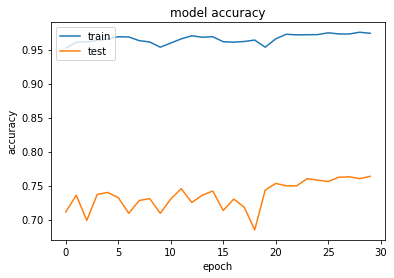

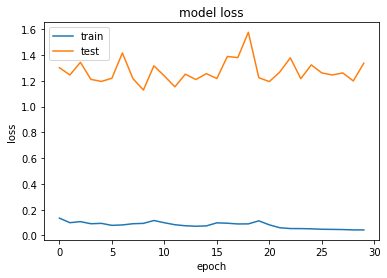

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
